In [1]:
import pandas as pd
import numpy as np
import gc
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
from category_encoders import TargetEncoder
from sklearn.utils.class_weight import compute_sample_weight

# ======================================
# 1. MEMORY-EFFICIENT LOAD
# ======================================
print(">>> Loading Data...")
cols_to_load = [
    'Severity', 'Distance(mi)', 'Temperature(F)', 'Visibility(mi)', 
    'Humidity(%)', 'Pressure(in)', 'Wind_Speed(mph)', 'Weather_Condition', 
    'Traffic_Signal', 'Junction', 'Crossing', 'Stop', 'Start_Time', 
    'State', 'City', 'Description'
]

df = pd.read_parquet("US_Accidents_March23.parquet", columns=cols_to_load)

# --- MEMORY OPTIMIZATION: DYNAMIC UNDERSAMPLING ---
print(">>> Balancing classes to match Severity 4 count...")

# 1. Get the target count from Severity 4
n_sev4 = len(df[df['Severity'] == 4])
print(f"Target count (Severity 4): {n_sev4}")

# 2. Separate the classes
df_1 = df[df['Severity'] == 1]
df_2 = df[df['Severity'] == 2]
df_3 = df[df['Severity'] == 3]
df_4 = df[df['Severity'] == 4]

# 3. Downsample Severity 2 and 3 to match Severity 4
# We use replace=False to ensure unique rows. 
# Added a check in case a class has fewer samples than Severity 4.
df_2_down = df_2.sample(n=min(len(df_2), n_sev4), random_state=42)
df_3_down = df_3.sample(n=min(len(df_3), n_sev4), random_state=42)

# 4. Concatenate back together (leaving Severity 1 as is)
df = pd.concat([df_1, df_2_down, df_3_down, df_4])

# 5. Shuffle the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f">>> Data shape after balancing: {df.shape}")
print("Final Value Counts:")
print(df['Severity'].value_counts())

# Cleanup to free RAM
del df_1, df_2, df_3, df_4, df_2_down, df_3_down
gc.collect()



>>> Loading Data...
>>> Balancing classes to match Severity 4 count...
Target count (Severity 4): 204710
>>> Data shape after balancing: (681496, 16)
Final Value Counts:
Severity
4    204710
2    204710
3    204710
1     67366
Name: count, dtype: int64


24

>>> Generating distribution chart...


C:\Users\fokunlola\AppData\Local\Temp\ipykernel_5180\2402229138.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=severity_dist.index, y=severity_dist.values, palette='viridis')


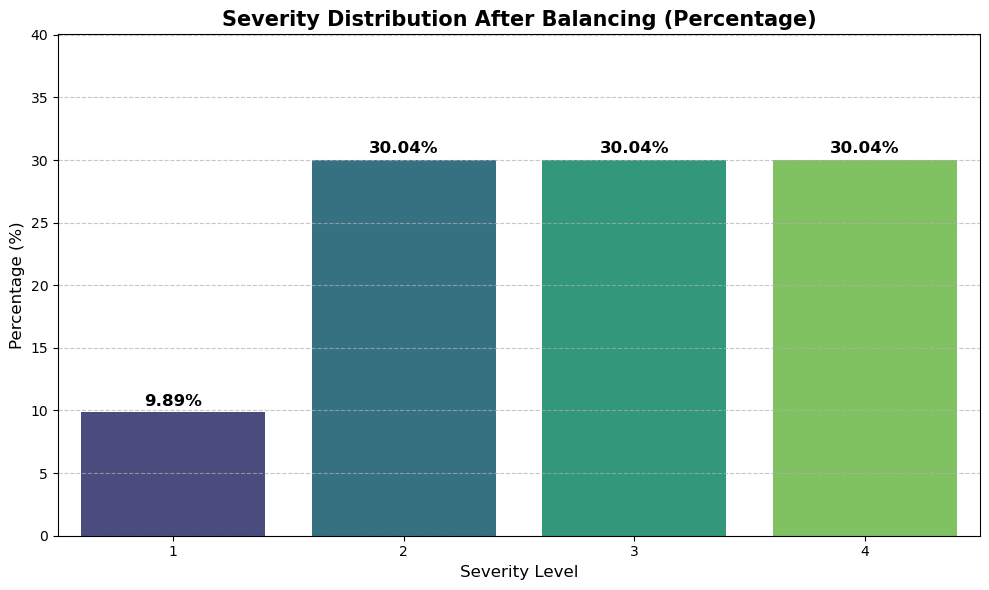

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# ======================================
# VISUALIZE DISTRIBUTION
# ======================================
print(">>> Generating distribution chart...")

# 1. Calculate value counts as percentages
# normalize=True gives proportions, * 100 converts to percentage
severity_dist = df['Severity'].value_counts(normalize=True).sort_index() * 100

# 2. Setup the plot
plt.figure(figsize=(10, 6))
# Using a color palette to distinguish bars
ax = sns.barplot(x=severity_dist.index, y=severity_dist.values, palette='viridis')

# 3. Add titles and labels
plt.title('Severity Distribution After Balancing (Percentage)', fontsize=15, fontweight='bold')
plt.xlabel('Severity Level', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)

# 4. Add the percentage text on top of each bar for clarity
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.,  # X center of the bar
        height + 0.5,                    # Slightly above the bar
        f'{height:.2f}%',                # Text formatted to 2 decimals
        ha="center", 
        fontsize=12, 
        fontweight='bold'
    )

# 5. Adjust layout and show
plt.ylim(0, max(severity_dist.values) + 10) # Add headroom for text
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [2]:
# ======================================
# 2. FEATURE ENGINEERING (FIXED)
# ======================================
print(">>> Engineering Features...")

# A. Datetime Fix
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')

#  DROP ROWS WITH NO START TIME BEFORE CONVERSION ---
# This prevents the IntCastingNaNError
df = df.dropna(subset=['Start_Time']) 

df['Hour'] = df['Start_Time'].dt.hour.astype('int8')
df['Month'] = df['Start_Time'].dt.month.astype('int8')
df['Weekday'] = df['Start_Time'].dt.weekday.astype('int8')

# Now safe to calculate derived features
df['Is_Weekend'] = (df['Weekday'] >= 5).astype('int8')
df['Is_Rush_Hour'] = df['Hour'].isin([7, 8, 17, 18]).astype('int8')

# B. Text Analysis (Description) -> Then Drop
df['Description'] = df['Description'].fillna('').str.lower()
df['Highway_Key'] = df['Description'].str.contains('highway|i-|interstate|exits', regex=True).astype('int8')
df['Blocked_Key'] = df['Description'].str.contains('blocked|closed', regex=True).astype('int8')
df.drop(columns=['Start_Time', 'Description'], inplace=True)

# C. Weather
df['Weather_Condition'] = df['Weather_Condition'].fillna('')
df['Rain'] = df['Weather_Condition'].str.contains('Rain|Storm|Thunder', case=False).astype('int8')
df['Snow'] = df['Weather_Condition'].str.contains('Snow|Ice|Blizzard', case=False).astype('int8')

# Handle missing values in numeric columns before comparison
df['Visibility(mi)'] = df['Visibility(mi)'].fillna(df['Visibility(mi)'].median())
df['Wind_Speed(mph)'] = df['Wind_Speed(mph)'].fillna(df['Wind_Speed(mph)'].median())

df['Low_Vis'] = (df['Visibility(mi)'] < 1).astype('int8')
df['High_Wind'] = (df['Wind_Speed(mph)'] > 25).astype('int8')
df.drop(columns=['Weather_Condition'], inplace=True)

# D. Booleans to Int (Fill NaNs first just in case)
bool_cols = ['Traffic_Signal', 'Junction', 'Crossing', 'Stop']
for c in bool_cols:
    df[c] = df[c].fillna(False).astype('int8')

# ======================================
# 3. PREPARATION FOR TRAINING
# ======================================
print(">>> Preparing Splits...")

# Target transformation (1-4 to 0-3 for XGBoost)
y = (df['Severity'] - 1).astype('int8')
X = df.drop(columns=['Severity'])

# Split FIRST to avoid Data Leakage in Target Encoding
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Free up memory
del df, X, y
gc.collect()

# ======================================
# 4. ENCODING (Fit on Train, Apply to Test)
# ======================================
print(">>> Target Encoding...")
encoder = TargetEncoder(cols=['State', 'City'])
# Fit on TRAIN
X_train[['State', 'City']] = encoder.fit_transform(X_train[['State', 'City']], y_train)
# Transform TEST
X_test[['State', 'City']] = encoder.transform(X_test[['State', 'City']])

# Ensure all types are float32 to save memory
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# ======================================
# 5. CALCULATE SAMPLE WEIGHTS
# ======================================
print(">>> Calculating Sample Weights...")
# This tells XGBoost: "Pay 30x more attention to Severity 4 than Severity 2"
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

# ======================================
# 6. TRAIN XGBOOST
# ======================================
print(">>> Training XGBoost...")

xgb = XGBClassifier(
    n_estimators=500,           # High number of trees
    learning_rate=0.05,         # Slower learning for better generalization
    max_depth=8,                # Deeper trees to catch complex interactions
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,                  # Use all CPU cores
    random_state=42,
    objective='multi:softprob',
    tree_method='hist',         # FASTEST method for large data
    early_stopping_rounds=20    # Stop if not improving
)

# Pass sample_weight here!
xgb.fit(
    X_train, y_train,
    sample_weight=sample_weights,
    eval_set=[(X_test, y_test)],
    verbose=50
)

# ======================================
# 7. EVALUATION
# ======================================
print("\n>>> Generating Predictions...")
y_pred = xgb.predict(X_test)

# Remap 0-3 back to 1-4 for display
print("\n===== CLASSIFICATION REPORT =====")
print(classification_report(y_test + 1, y_pred + 1))

print(f"Final Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Weighted F1:    {f1_score(y_test, y_pred, average='weighted'):.4f}")

# Feature Importance
print("\n===== TOP 5 FEATURE IMPORTANCE =====")
importances = pd.Series(xgb.feature_importances_, index=X_train.columns)
print(importances.sort_values(ascending=False).head(5))

>>> Engineering Features...
>>> Preparing Splits...
>>> Target Encoding...
>>> Calculating Sample Weights...
>>> Training XGBoost...
[0]	validation_0-mlogloss:1.33756
[50]	validation_0-mlogloss:0.59568
[100]	validation_0-mlogloss:0.51707
[150]	validation_0-mlogloss:0.49409
[200]	validation_0-mlogloss:0.48186
[250]	validation_0-mlogloss:0.47467
[300]	validation_0-mlogloss:0.46900
[350]	validation_0-mlogloss:0.46463
[400]	validation_0-mlogloss:0.46098
[450]	validation_0-mlogloss:0.45793
[499]	validation_0-mlogloss:0.45541

>>> Generating Predictions...

===== CLASSIFICATION REPORT =====
              precision    recall  f1-score   support

           1       0.69      0.91      0.79     13473
           2       0.85      0.75      0.80     36141
           3       0.89      0.83      0.86     40938
           4       0.85      0.91      0.88     36946

    accuracy                           0.84    127498
   macro avg       0.82      0.85      0.83    127498
weighted avg       0.85     

In [4]:
from sklearn.preprocessing import StandardScaler

print(">>> Scaling data for LogReg and LSTM...")
scaler = StandardScaler()
# Fit on train, transform both
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

>>> Scaling data for LogReg and LSTM...


In [6]:
import numpy as np

print("NaNs in X_train_scaled:", np.isnan(X_train_scaled).sum())
print("NaNs in X_test_scaled:", np.isnan(X_test_scaled).sum())

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

X_train_scaled = imputer.fit_transform(X_train_scaled)
X_test_scaled = imputer.transform(X_test_scaled)

from sklearn.linear_model import LogisticRegression

print(">>> Training Logistic Regression...")
# solver='saga' is faster for large datasets; multi_class='multinomial' for 4 severities
log_reg = LogisticRegression(
    solver='saga', 
    multi_class='multinomial', 
    max_iter=1000, 
    n_jobs=-1, 
    random_state=42
)

log_reg.fit(X_train_scaled, y_train, sample_weight=sample_weights)

print("\n===== LOGISTIC REGRESSION RESULTS =====")
y_pred_lr = log_reg.predict(X_test_scaled)
print(classification_report(y_test + 1, y_pred_lr + 1))

NaNs in X_train_scaled: 34442
NaNs in X_test_scaled: 8386
>>> Training Logistic Regression...


C:\Users\fokunlola\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



===== LOGISTIC REGRESSION RESULTS =====
              precision    recall  f1-score   support

           1       0.44      0.71      0.54     13473
           2       0.72      0.47      0.57     36141
           3       0.70      0.81      0.75     40938
           4       0.79      0.74      0.76     36946

    accuracy                           0.68    127498
   macro avg       0.66      0.68      0.66    127498
weighted avg       0.70      0.68      0.68    127498



In [12]:
from sklearn.ensemble import RandomForestClassifier

print(">>> Training Random Forest...")
rf = RandomForestClassifier(
    n_estimators=200,      # Number of trees
    max_depth=12,          # Limit depth to prevent RAM explosion
    n_jobs=-1,             # Use all cores
    random_state=42,
    verbose=1
)

rf.fit(X_train, y_train, sample_weight=sample_weights)

print("\n===== RANDOM FOREST RESULTS =====")
y_pred_rf = rf.predict(X_test)
print(classification_report(y_test + 1, y_pred_rf + 1))

>>> Training Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.5min finished



===== RANDOM FOREST RESULTS =====


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    1.6s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    1.8s finished


              precision    recall  f1-score   support

           1       0.60      0.87      0.71     13473
           2       0.79      0.70      0.74     36141
           3       0.90      0.77      0.83     40938
           4       0.82      0.91      0.86     36946

    accuracy                           0.80    127498
   macro avg       0.78      0.81      0.79    127498
weighted avg       0.81      0.80      0.80    127498



In [10]:
from catboost import CatBoostClassifier

print(">>> Training CatBoost...")
cat = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=8,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    random_seed=42,
    verbose=50,
    allow_writing_files=False
)

# CatBoost handles sample weights internally well
cat.fit(
    X_train, y_train,
    sample_weight=sample_weights,
    eval_set=(X_test, y_test),
    early_stopping_rounds=20
)

print("\n===== CATBOOST RESULTS =====")
y_pred_cat = cat.predict(X_test)
print(classification_report(y_test + 1, y_pred_cat + 1))

>>> Training CatBoost...
0:	learn: 0.7882092	test: 0.7774553	best: 0.7774553 (0)	total: 848ms	remaining: 7m 3s
50:	learn: 0.8027772	test: 0.7900595	best: 0.7900595 (50)	total: 37.1s	remaining: 5m 26s
100:	learn: 0.8103187	test: 0.7977851	best: 0.7977851 (100)	total: 1m 11s	remaining: 4m 42s
150:	learn: 0.8176062	test: 0.8048283	best: 0.8048283 (150)	total: 1m 45s	remaining: 4m 3s
200:	learn: 0.8225735	test: 0.8100833	best: 0.8100833 (200)	total: 2m 19s	remaining: 3m 27s
250:	learn: 0.8265847	test: 0.8136284	best: 0.8136284 (250)	total: 2m 53s	remaining: 2m 51s
300:	learn: 0.8301144	test: 0.8168207	best: 0.8168207 (300)	total: 3m 27s	remaining: 2m 16s
350:	learn: 0.8331072	test: 0.8194560	best: 0.8194560 (350)	total: 4m	remaining: 1m 41s
400:	learn: 0.8355360	test: 0.8214796	best: 0.8215266 (395)	total: 4m 33s	remaining: 1m 7s
450:	learn: 0.8375145	test: 0.8233462	best: 0.8233855 (448)	total: 5m 7s	remaining: 33.4s
499:	learn: 0.8393186	test: 0.8247110	best: 0.8247110 (499)	total: 5m 39

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

print(">>> Preparing Data for LSTM...")
# 1. Reshape inputs to [samples, time_steps, features]
# We use 1 time step because the rows are independent events
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# 2. One-hot encode targets (Keras expects this for multi-class)
y_train_ohe = to_categorical(y_train)
y_test_ohe = to_categorical(y_test)

print(">>> Building LSTM Model...")
model = Sequential()
# Input shape: (1 time step, n features)
model.add(LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), activation='relu'))
model.add(Dropout(0.2)) # Prevent overfitting
model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='softmax')) # 4 output classes (Severity 1-4)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(">>> Training LSTM...")
# We use class_weight dictionary instead of sample_weight array for Keras mostly, 
# but sample_weight is supported in .fit(). We will use the computed sample_weights.
history = model.fit(
    X_train_lstm, y_train_ohe,
    epochs=10,
    batch_size=1024, # Large batch size for speed
    validation_data=(X_test_lstm, y_test_ohe),
    sample_weight=sample_weights,
    verbose=1
)

print("\n===== LSTM RESULTS =====")
y_pred_probs = model.predict(X_test_lstm)
y_pred_lstm = np.argmax(y_pred_probs, axis=1)
print(classification_report(y_test + 1, y_pred_lstm + 1))

>>> Preparing Data for LSTM...
>>> Building LSTM Model...


C:\Users\fokunlola\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


>>> Training LSTM...
Epoch 1/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.6596 - loss: 0.8415 - val_accuracy: 0.7380 - val_loss: 0.7048
Epoch 2/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.7385 - loss: 0.6902 - val_accuracy: 0.7504 - val_loss: 0.6637
Epoch 3/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.7552 - loss: 0.6495 - val_accuracy: 0.7720 - val_loss: 0.6209
Epoch 4/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.7677 - loss: 0.6241 - val_accuracy: 0.7754 - val_loss: 0.6140
Epoch 5/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.7750 - loss: 0.6085 - val_accuracy: 0.7852 - val_loss: 0.5915
Epoch 6/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.7795 - loss: 0.5984 - val_accuracy: 0.7843 - val_loss: 0.5988
Epoch 7/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.7826 - loss: 0.5919 - val_accuracy: 0.7879 - val_loss: 0.5883
Epoch 8/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.7

>>> Compiling Model Comparison...

===== FINAL MODEL LEADERBOARD =====
              Model  Accuracy  Weighted F1
            XGBoost  0.839048     0.838966
           CatBoost  0.824711     0.825072
      Random Forest  0.800718     0.801674
               LSTM  0.788224     0.789221
Logistic Regression  0.682246     0.679891


C:\Users\fokunlola\AppData\Local\Temp\ipykernel_12840\1340930065.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_results.sort_values(by='Weighted F1', ascending=False), x='Model', y='Weighted F1', palette='magma')


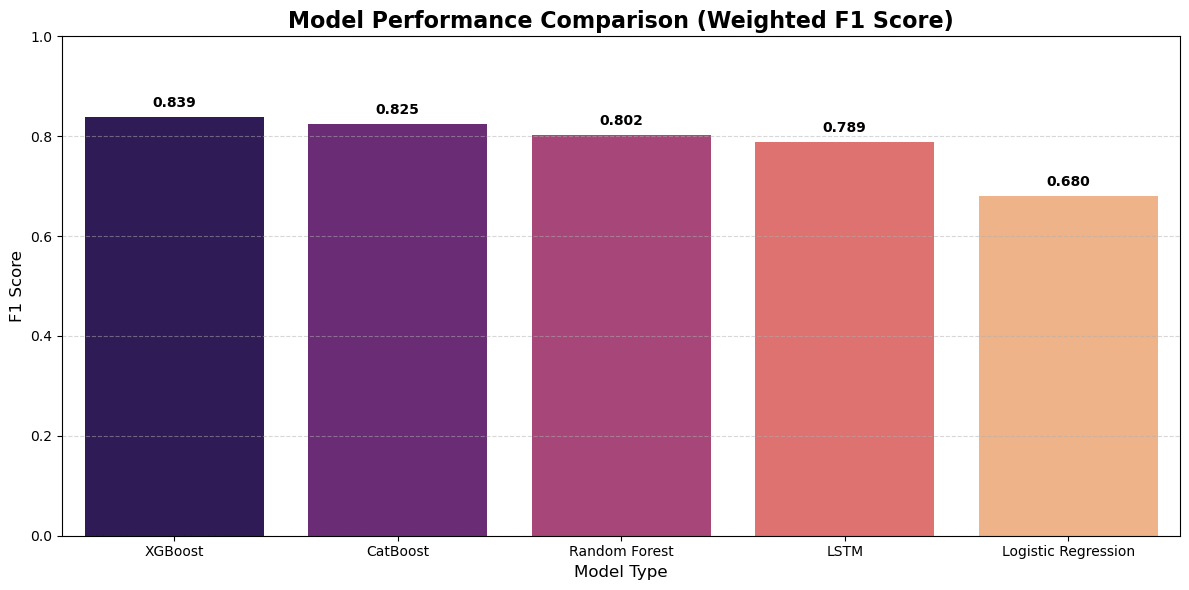

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ======================================
# 8. MODEL COMPARISON
# ======================================
print(">>> Compiling Model Comparison...")

# 1. Collect Scores (Assuming variables from previous steps exist: y_pred, y_pred_lr, y_pred_rf, y_pred_cat, y_pred_lstm)
# Note: 'y_pred' refers to your original XGBoost prediction

models_data = {
    'Model': ['XGBoost', 'Logistic Regression', 'Random Forest', 'CatBoost', 'LSTM'],
    'Accuracy': [
        accuracy_score(y_test, y_pred),
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_cat),
        accuracy_score(y_test, y_pred_lstm)
    ],
    'Weighted F1': [
        f1_score(y_test, y_pred, average='weighted'),
        f1_score(y_test, y_pred_lr, average='weighted'),
        f1_score(y_test, y_pred_rf, average='weighted'),
        f1_score(y_test, y_pred_cat, average='weighted'),
        f1_score(y_test, y_pred_lstm, average='weighted')
    ]
}

df_results = pd.DataFrame(models_data)

# 2. Display the Table
print("\n===== FINAL MODEL LEADERBOARD =====")
print(df_results.sort_values(by='Weighted F1', ascending=False).to_string(index=False))

# 3. Visualize Comparison
plt.figure(figsize=(12, 6))
sns.barplot(data=df_results.sort_values(by='Weighted F1', ascending=False), x='Model', y='Weighted F1', palette='magma')

plt.title('Model Performance Comparison (Weighted F1 Score)', fontsize=16, fontweight='bold')
plt.ylim(0, 1.0)
plt.ylabel('F1 Score', fontsize=12)
plt.xlabel('Model Type', fontsize=12)

# Add text labels on bars
for i, row in enumerate(df_results.sort_values(by='Weighted F1', ascending=False).itertuples()):
    plt.text(i, row._3 + 0.02, f'{row._3:.3f}', ha='center', fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

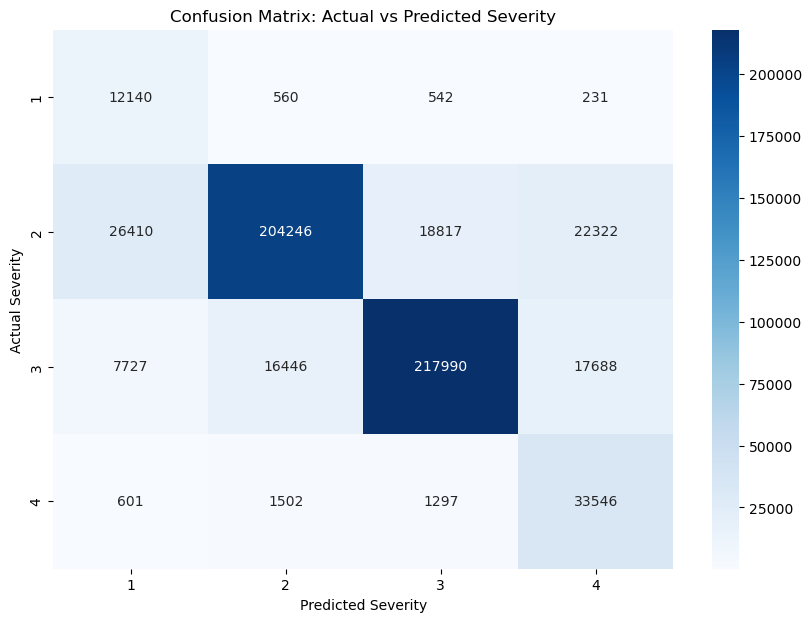

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Calculate Confusion Matrix
cm = confusion_matrix(y_test + 1, y_pred + 1) # Add 1 to get 1-4 scale

# 2. Plotting
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[1, 2, 3, 4], 
            yticklabels=[1, 2, 3, 4])

plt.title('Confusion Matrix: Actual vs Predicted Severity')
plt.ylabel('Actual Severity')
plt.xlabel('Predicted Severity')
plt.show()

<Figure size 1200x600 with 0 Axes>

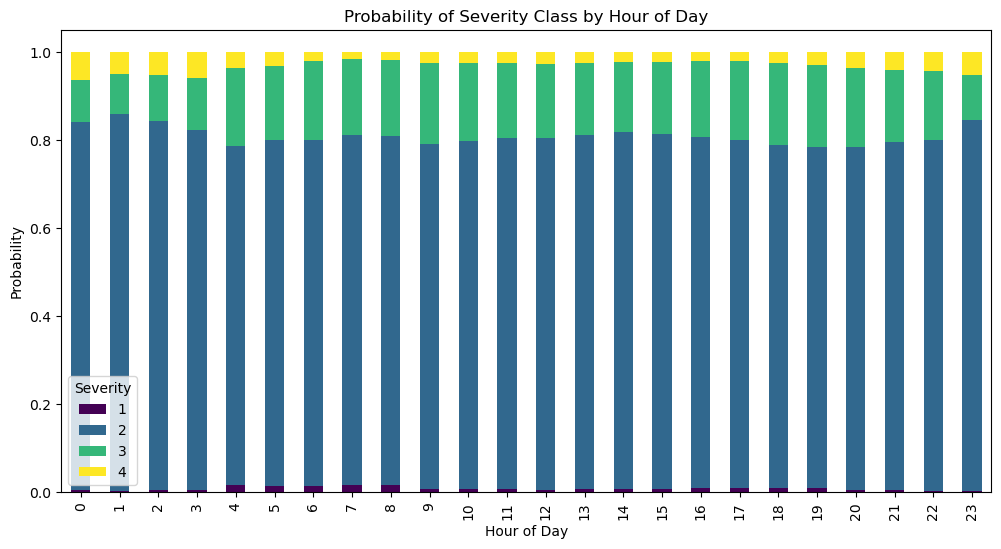

C:\Users\fokunlola\AppData\Local\Temp\ipykernel_24716\4200279542.py:30: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_raw['Is_Highway'] = df_raw['Description'].str.contains('highway|I-', case=False, regex=True).fillna(False)


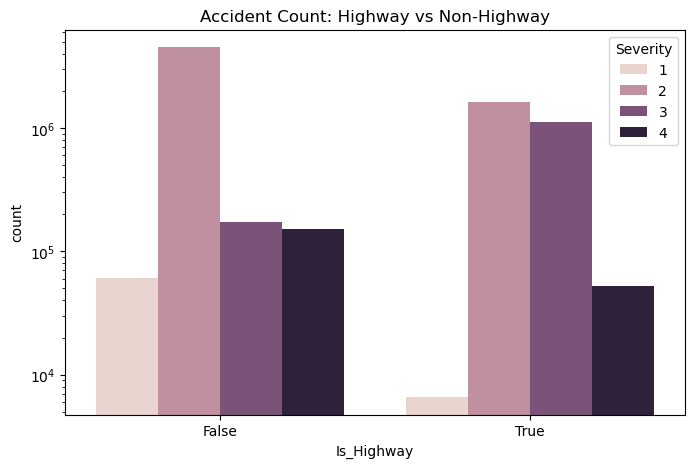

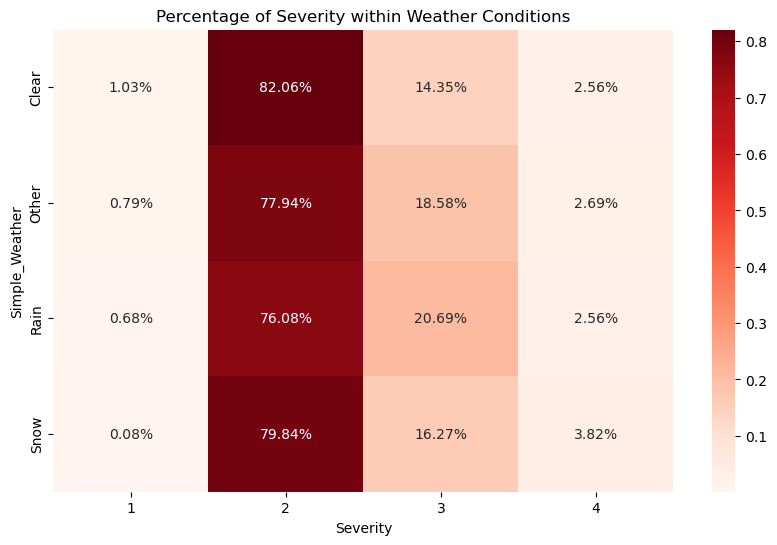

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df_raw' is your dataframe BEFORE the one-hot encoding/dropping
# If you don't have it in memory, reload a sample:
df_raw = pd.read_parquet("US_Accidents_March23.parquet")
df_raw['Start_Time'] = df_raw['Start_Time'].astype(str).str.slice(0,19)
df_raw['Start_Time'] = pd.to_datetime(df_raw['Start_Time'], format='%Y-%m-%d %H:%M:%S')

df_raw['Hour'] = df_raw['Start_Time'].dt.hour

# ==========================================
# 1. THE HOURLY RISK (Time vs Severity)
# ==========================================
plt.figure(figsize=(12, 6))
# We normalize by column (probability of severity given the hour)
crosstab = pd.crosstab(df_raw['Hour'], df_raw['Severity'], normalize='index')
crosstab.plot(kind='bar', stacked=True, colormap='viridis', figsize=(12,6))

plt.title('Probability of Severity Class by Hour of Day')
plt.ylabel('Probability')
plt.xlabel('Hour of Day')
plt.legend(title='Severity')
plt.show()
# LOOK FOR: The yellow/green bars (Severity 3/4) getting larger at night (0-5 AM).

# ==========================================
# 2. THE HIGHWAY EFFECT
# ==========================================
df_raw['Is_Highway'] = df_raw['Description'].str.contains('highway|I-', case=False, regex=True).fillna(False)

plt.figure(figsize=(8, 5))
sns.countplot(x='Is_Highway', hue='Severity', data=df_raw)
plt.title('Accident Count: Highway vs Non-Highway')
plt.yscale('log') # Log scale because Severity 2 is so huge
plt.show()
# LOOK FOR: The ratio of Severity 4 to Severity 2 being higher on Highways.

# ==========================================
# 3. WEATHER IMPACT
# ==========================================
# Simplify weather for plotting
def simple_weather(w):
    w = str(w).lower()
    if 'rain' in w or 'storm' in w: return 'Rain'
    if 'snow' in w or 'ice' in w: return 'Snow'
    if 'clear' in w or 'fair' in w: return 'Clear'
    return 'Other'

df_raw['Simple_Weather'] = df_raw['Weather_Condition'].apply(simple_weather)

plt.figure(figsize=(10, 6))
props = pd.crosstab(df_raw['Simple_Weather'], df_raw['Severity'], normalize='index')
sns.heatmap(props, annot=True, fmt=".2%", cmap="Reds")
plt.title('Percentage of Severity within Weather Conditions')
plt.show()
# LOOK FOR: Is Severity 4 higher in 'Clear' than in 'Rain'?

>>> Loading Data...
>>> Processing Temporal Trends...


C:\Users\fokunlola\AppData\Local\Temp\ipykernel_12840\237519148.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=days, y=counts_weekday.values, palette='viridis')


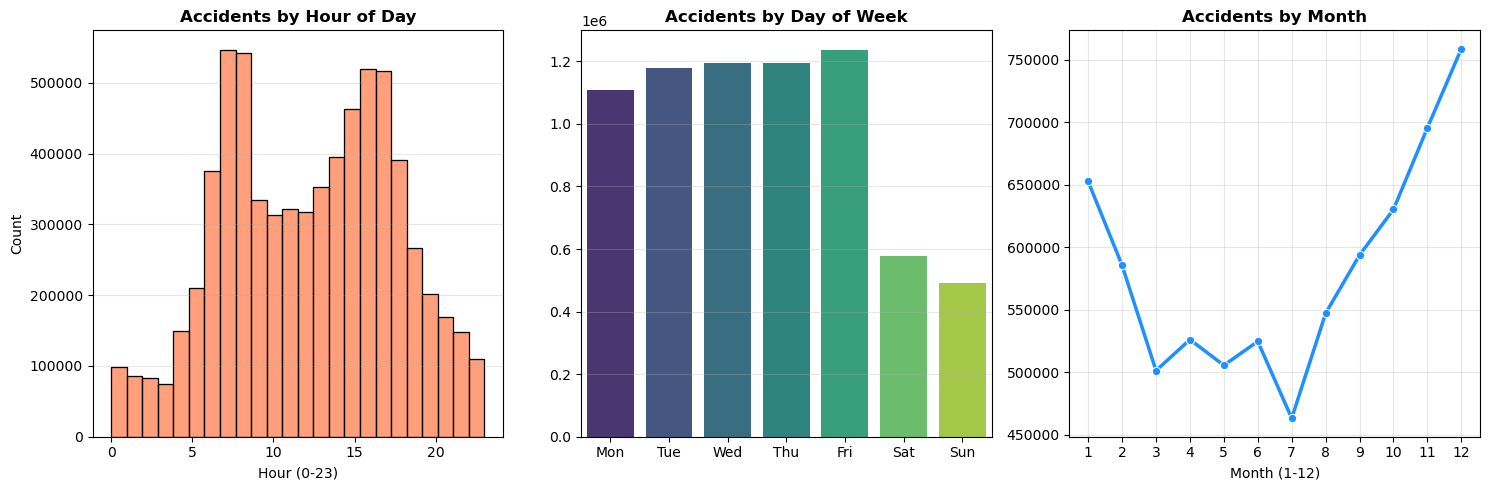


>>> Running DBSCAN Hotspot Detection on Miami...


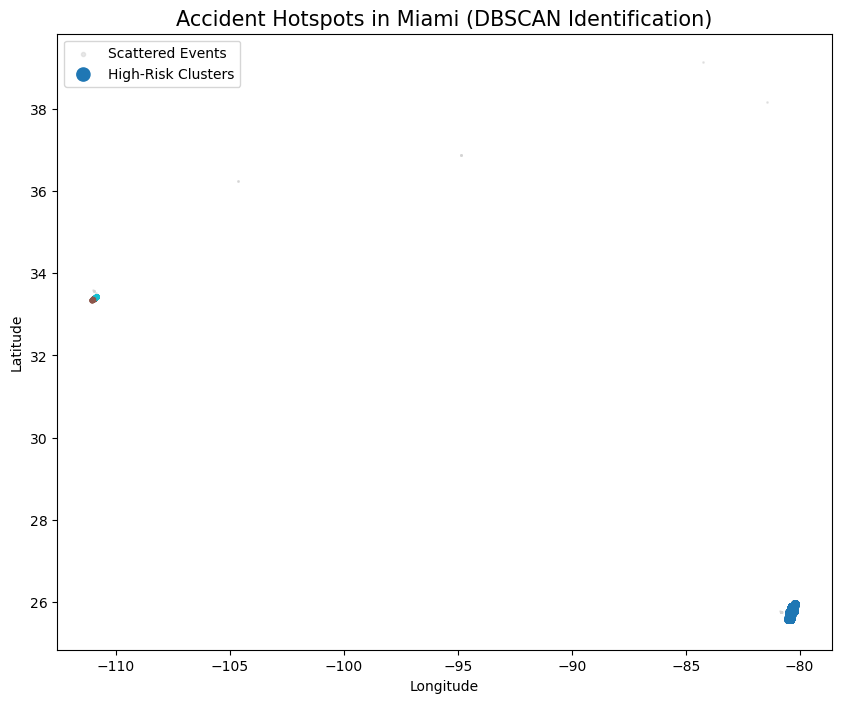


>>> Generating US Macro-Density Map...


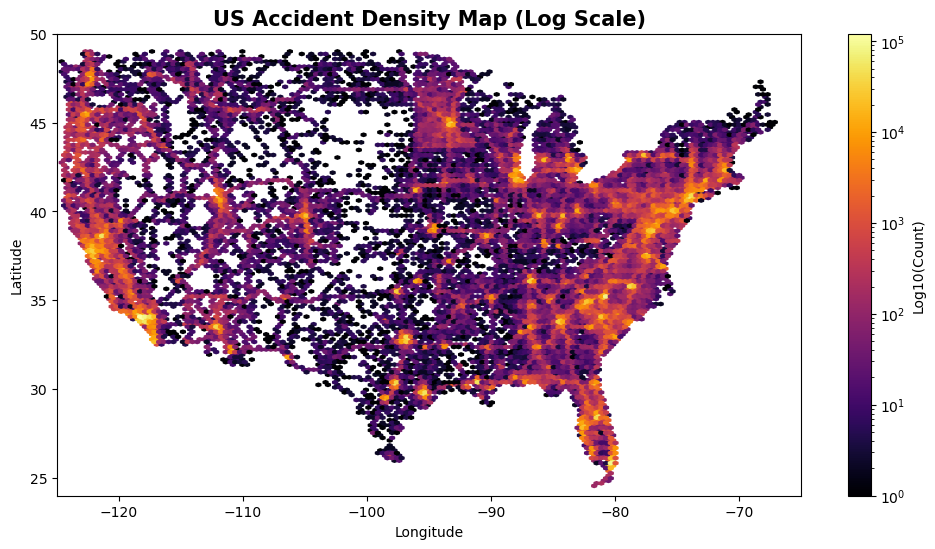

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import gc

# ==========================================
# 1. LOAD DATA (Assuming file exists)
# ==========================================
# We only need specific columns for this analysis
cols = ['Start_Time', 'Start_Lat', 'Start_Lng', 'City', 'State']
print(">>> Loading Data...")
df = pd.read_parquet("US_Accidents_March23.parquet", columns=cols)

# ==========================================
# 2. TEMPORAL ANALYSIS
# ==========================================
print(">>> Processing Temporal Trends...")
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df = df.dropna(subset=['Start_Time', 'Start_Lat', 'Start_Lng'])

# Extract time features
df['Hour'] = df['Start_Time'].dt.hour
df['Weekday'] = df['Start_Time'].dt.weekday  # 0=Monday, 6=Sunday
df['Month'] = df['Start_Time'].dt.month

# --- PLOT 1: Accidents by Hour (Rush Hour Check) ---
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(df['Hour'], bins=24, kde=False, color='coral', edgecolor='black')
plt.title('Accidents by Hour of Day', fontsize=12, fontweight='bold')
plt.xlabel('Hour (0-23)')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.3)

# --- PLOT 2: Accidents by Weekday ---
plt.subplot(1, 3, 2)
# Map 0-6 to Mon-Sun
counts_weekday = df['Weekday'].value_counts().sort_index()
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
sns.barplot(x=days, y=counts_weekday.values, palette='viridis')
plt.title('Accidents by Day of Week', fontsize=12, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# --- PLOT 3: Accidents by Month ---
plt.subplot(1, 3, 3)
counts_month = df['Month'].value_counts().sort_index()
sns.lineplot(x=counts_month.index, y=counts_month.values, marker='o', linewidth=2.5, color='dodgerblue')
plt.title('Accidents by Month', fontsize=12, fontweight='bold')
plt.xlabel('Month (1-12)')
plt.grid(True, alpha=0.3)
plt.xticks(range(1, 13))

plt.tight_layout()
plt.show()

# ==========================================
# 3. SPATIAL HOTSPOT ALGORITHM (DBSCAN)
# ==========================================
# NOTE: DBSCAN is computationally expensive on millions of rows. 
# We will demonstrate it on a SINGLE HIGH-RISK CITY (e.g., Miami) 
# to show how it identifies specific intersections/highway stretches.

TARGET_CITY = 'Miami'
print(f"\n>>> Running DBSCAN Hotspot Detection on {TARGET_CITY}...")

# Filter data
city_df = df[df['City'] == TARGET_CITY].copy()
coords = city_df[['Start_Lat', 'Start_Lng']].values

# 1. Scale coordinates (DBSCAN needs comparable scales)
# Ideally, we project to meters (UTM), but for a city, scaling is a quick approx.
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)

# 2. Run DBSCAN
# eps=0.05: The radius to search for neighbors (tuned for scaled lat/lng)
# min_samples=20: Cluster must have at least 20 accidents to be a "Hotspot"
db = DBSCAN(eps=0.05, min_samples=20, n_jobs=-1).fit(coords_scaled)

city_df['Cluster'] = db.labels_

# 3. Visualize Hotspots
plt.figure(figsize=(10, 8))
# Plot 'Noise' (non-hotspots) as small grey dots
noise = city_df[city_df['Cluster'] == -1]
plt.scatter(noise['Start_Lng'], noise['Start_Lat'], s=1, c='lightgrey', alpha=0.5, label='Scattered Events')

# Plot 'Clusters' (Hotspots) with colors
hotspots = city_df[city_df['Cluster'] != -1]
plt.scatter(hotspots['Start_Lng'], hotspots['Start_Lat'], s=10, c=hotspots['Cluster'], cmap='tab10', label='High-Risk Clusters')

plt.title(f'Accident Hotspots in {TARGET_CITY} (DBSCAN Identification)', fontsize=15)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(markerscale=3)
plt.show()

# ==========================================
# 4. MACRO SPATIAL DENSITY (US MAP)
# ==========================================
print("\n>>> Generating US Macro-Density Map...")
plt.figure(figsize=(12, 6))
# Hexbin allows us to visualize density for millions of points efficiently
plt.hexbin(df['Start_Lng'], df['Start_Lat'], gridsize=150, cmap='inferno', mincnt=1, bins='log')
plt.title('US Accident Density Map (Log Scale)', fontsize=15, fontweight='bold')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Log10(Count)')
# Limit to Continental US approximate box
plt.xlim(-125, -65)
plt.ylim(24, 50)
plt.show()

>>> Plotting XGBoost Feature Importance...


C:\Users\fokunlola\AppData\Local\Temp\ipykernel_12840\533243231.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_imp, x='Gain', y='Feature', palette='viridis')


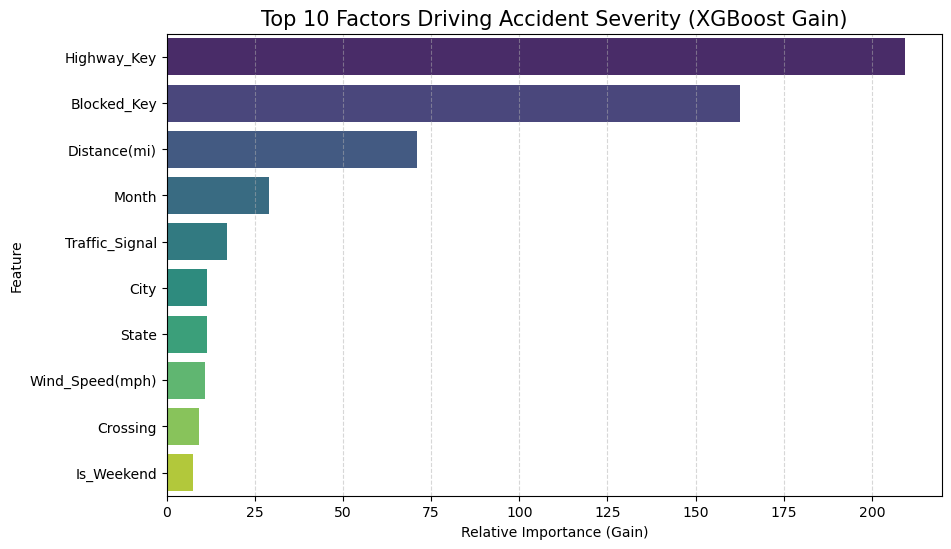

>>> Calculating SHAP Values (this may take a moment)...


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

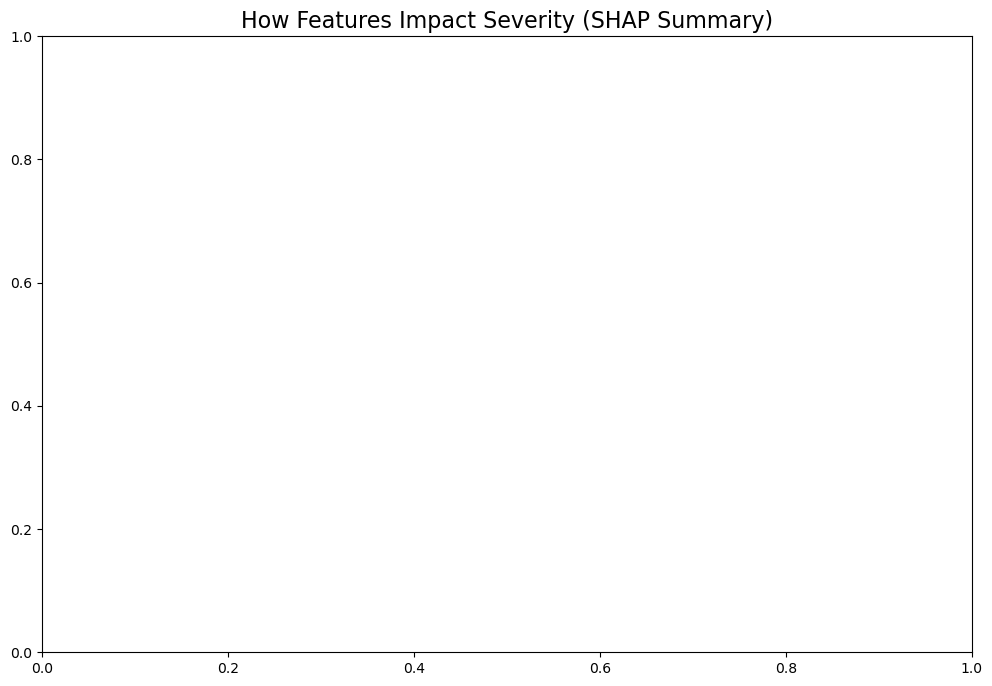

In [15]:
import shap
import matplotlib.pyplot as plt
import pandas as pd

# ======================================
# 1. TRADITIONAL FEATURE IMPORTANCE
# ======================================
print(">>> Plotting XGBoost Feature Importance...")
# Get importance dictionary
importance = xgb.get_booster().get_score(importance_type='gain')
# Convert to DataFrame
df_imp = pd.DataFrame(list(importance.items()), columns=['Feature', 'Gain'])
df_imp = df_imp.sort_values(by='Gain', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_imp, x='Gain', y='Feature', palette='viridis')
plt.title('Top 10 Factors Driving Accident Severity (XGBoost Gain)', fontsize=15)
plt.xlabel('Relative Importance (Gain)')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

# ======================================
# 2. SHAP ANALYSIS (The "Why")
# ======================================
print(">>> Calculating SHAP Values (this may take a moment)...")

# Use a small sample for speed (SHAP is slow on large data)
X_shap = X_test.sample(2000, random_state=42)

# Create the explainer
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_shap)

# SHAP Summary Plot
# This shows the direction of the impact (Red = High Value, Blue = Low Value)
plt.figure(figsize=(12, 8))
plt.title("How Features Impact Severity (SHAP Summary)", fontsize=16)
# Class 3 (Severity 4) is usually the last index in the shap_values list for XGBClassifier
# We plot the impact on the "Most Severe" class
shap.summary_plot(shap_values[3], X_shap, show=False) 
plt.show()

100%|===================| 7998/8000 [122:48<00:01]        

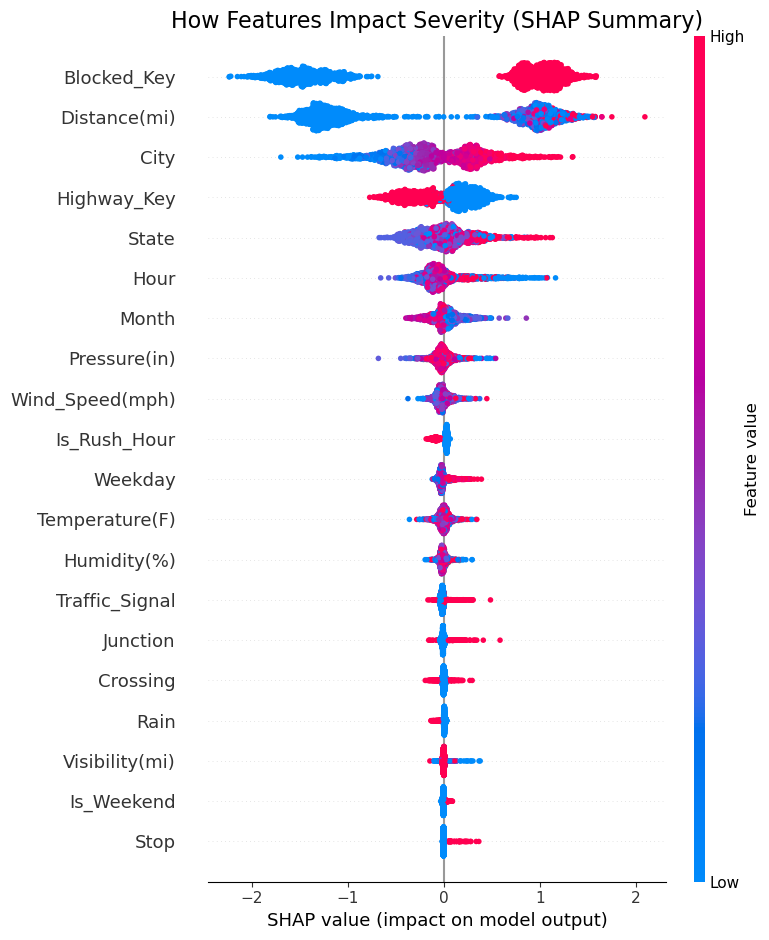

In [16]:


# Sample data
X_shap = X_test.sample(2000, random_state=42)

# Create explainer (new API)
explainer = shap.Explainer(xgb, X_shap)

# Compute SHAP values
shap_values = explainer(X_shap)

# Check shape:
# shap_values.values.shape == (n_samples, n_features, n_classes)

# Select Class 3 (Severity 4)
class_idx = 3

plt.figure(figsize=(12, 8))
plt.title("How Features Impact Severity (SHAP Summary)", fontsize=16)

shap.summary_plot(
    shap_values.values[:, :, class_idx],  # correct slicing
    X_shap,
    show=False
)

plt.show()


>>> Chart saved successfully as 'shap_impact_analysis.png'


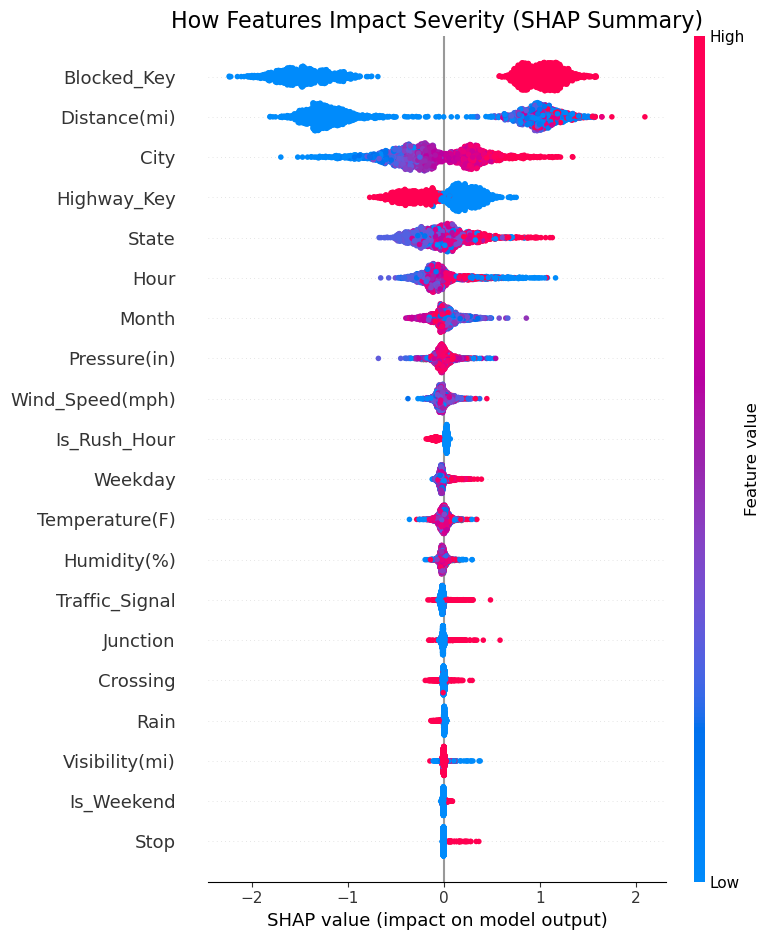

In [17]:
plt.figure(figsize=(12, 8))
plt.title("How Features Impact Severity (SHAP Summary)", fontsize=16)

shap.summary_plot(
    shap_values.values[:, :, class_idx],  # correct slicing
    X_shap,
    show=False
)

# 2. Save the figure as a PNG
# bbox_inches='tight' prevents labels from being cut off
# dpi=300 gives you high resolution for reports/slides
plt.savefig('shap_impact_analysis.png', format='png', bbox_inches='tight', dpi=300)

print(">>> Chart saved successfully as 'shap_impact_analysis.png'")

In [5]:
from lime.lime_tabular import LimeTabularExplainer
import numpy as np

explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=['Severity 1','Severity 2','Severity 3','Severity 4'],
    mode='classification',
    discretize_continuous=False   
)

# Explain single prediction
i = 10  # sample index
exp = explainer.explain_instance(
    X_test.iloc[i],
    xgb.predict_proba,
    num_features=10
)

exp.show_in_notebook()
